<a href="https://colab.research.google.com/github/lizalanchu/Cars_Moldova_homework1-/blob/main/%D0%94%D0%B73_Car_Moldova_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии. 

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр. 

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии. 
 
 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

# Import библиотек

In [1]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Oчищенный набор данных

## Загрузка данных на Google Drive

In [2]:
uploaded = files.upload()

Saving cars_moldova_clean1.csv to cars_moldova_clean1.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [3]:
df = pd.read_csv('/content/cars_moldova_clean1.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,1,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,0,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,0,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,0,4000.0,16,23125.000000


In [4]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

## Логистическая регрессия

рассмотрим графики функции активации сигмоид и ее производной

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z)) 

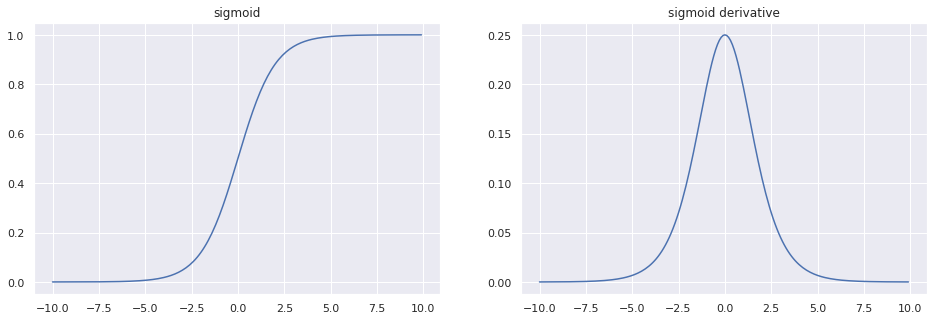

In [6]:
z = np.arange(-10,10,0.1)

plt.figure(figsize=(16,5))
plt.subplot(121); plt.plot(z,sigmoid(z)); plt.title('sigmoid')
plt.subplot(122); plt.plot(z,sigmoid_derivative(z)); plt.title('sigmoid derivative')
plt.show()

Как правило, после расчета функции активации мы должны округлить значения до 0 или до 1. То есть до значения метки одного из классов. Такое округление можно сделать по заданному порогу результатов функции активации. Например, мы можем сказать, что если значение сигмоида больше 0.5 то пусть будет класс 1, а если меньше, то наоборот. 

Однако, на практике иногда ставят высокий порог, 0.7 - 0.8. 

Запишем функцию определения класса.

Отметим, что в описанном смысле можно говорить о том, что результат сигмоида - это вероятность того, что аргумент функции (z) принадлежит одному из классов. Также отметим, что такой аргумент принято называть логит.



In [7]:
def to_class(logit, threshold = 0.5):
    return (logit>=threshold)*1

In [8]:
print( to_class(sigmoid(2.5), threshold = 0.7), ',',  to_class(sigmoid(-2.5), threshold = 0.7) )

1 , 0


Отметим, что для расчета функции потерь не следует пользоваться округлением до классов

Теперь рассмотрим функцию потерь. Отметим, что значениях логорифма мы ввели небольшую константу с целью исключить ошибку вида логорифм нуля.

In [9]:
_EPS_ = 1e-6
def loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

для начала рассмотрим значение функции активации для предельных случаев значений вероятности.

In [10]:
print('неопределенность (yhat=0.5, y=1):\t %.3f'%loss(yhat=0.5, y=1))
print('неопределенность (yhat=0.5, y=0):\t %.3f'%loss(yhat=0.5, y=0))
print('уверенный 0 класс (yhat=0, y=0):\t %.3f'%loss(yhat=0.0, y=0))
print('уверенный 1 класс(yhat=1, y=1):\t %.3f'%loss(yhat=1, y=1))
print('ошибочный 0 класс (yhat=0, y=1):\t %.3f'%loss(yhat=0.0, y=1))
print('ошибочный 1 класс(yhat=1, y=0):\t %.3f'%loss(yhat=1, y=0))

неопределенность (yhat=0.5, y=1):	 0.693
неопределенность (yhat=0.5, y=0):	 0.693
уверенный 0 класс (yhat=0, y=0):	 -0.000
уверенный 1 класс(yhat=1, y=1):	 -0.000
ошибочный 0 класс (yhat=0, y=1):	 13.816
ошибочный 1 класс(yhat=1, y=0):	 13.816


Запишем все в один класс. Также добавим в функцию эластичную регуляризацию.

In [11]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [12]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)* self.l1_penalty + l2_term)

In [13]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Запишим данные для классификации.

In [14]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4
22549,0.40,0.011012,0.291667,0.006513,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.248497


Проведем тестирование без регуляризации 

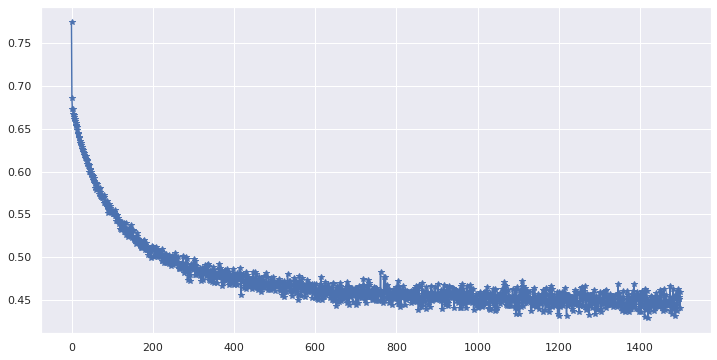

train Accuracy: 0.8074; test Accuracy: 0.8098
True Positives:3270	False Positives:703
False Negatives:1135	True Negatives:4558
Accuracy:0.8098
Recall:0.7423	Precision:0.8231
f1 measure:0.7806


In [15]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

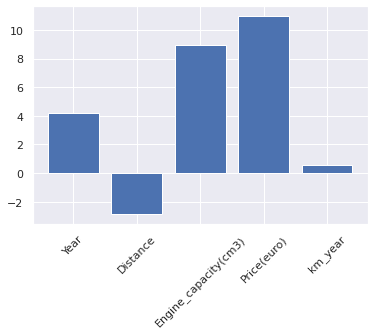

In [16]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с регуляризацией L2

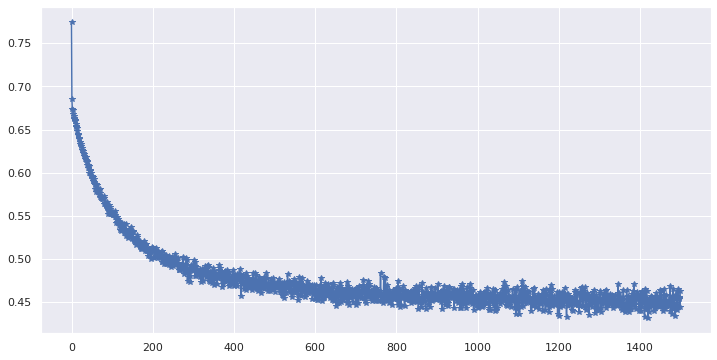

train Accuracy: 0.8050; test Accuracy: 0.8081
True Positives:3261	False Positives:711
False Negatives:1144	True Negatives:4550
Accuracy:0.8081
Recall:0.7403	Precision:0.8210
f1 measure:0.7786


In [17]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

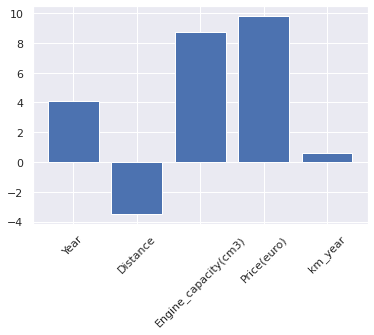

In [18]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

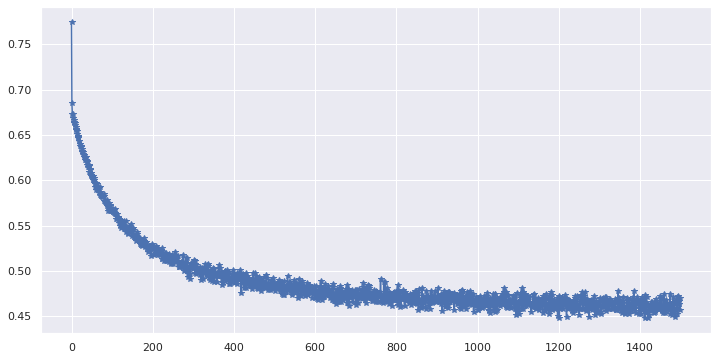

train Accuracy: 0.8070; test Accuracy: 0.8133
True Positives:3220	False Positives:620
False Negatives:1185	True Negatives:4641
Accuracy:0.8133
Recall:0.7310	Precision:0.8385
f1 measure:0.7811


In [19]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

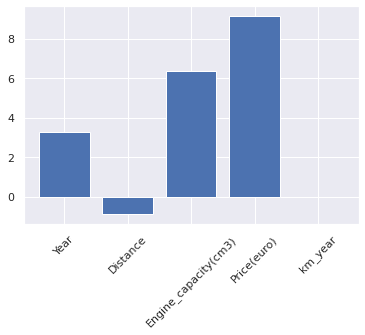

In [20]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Эластичная регрессия

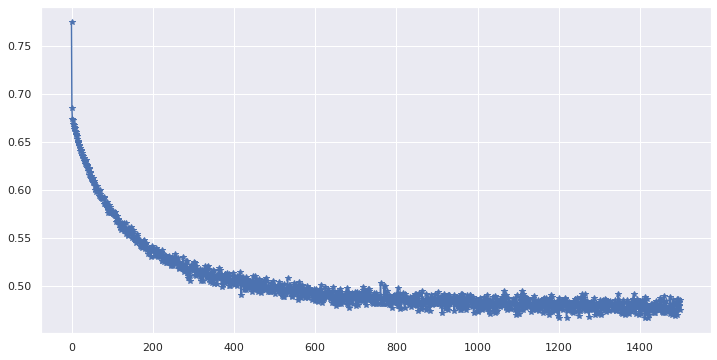

train Accuracy: 0.8058; test Accuracy: 0.8132
True Positives:3171	False Positives:572
False Negatives:1234	True Negatives:4689
Accuracy:0.8132
Recall:0.7199	Precision:0.8472
f1 measure:0.7784


In [21]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

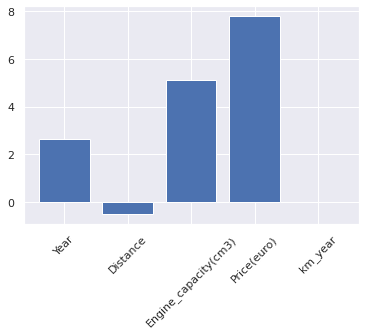

In [22]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Посмотрим, можно ли проводить классификацию без параметров связанных с расстоянием

In [23]:
w, b = regr.get_w_and_b()

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

train ACC: 0.8089; test ACC: 0.8162
True Positives:3299	False Positives:671
False Negatives:1106	True Negatives:4590
Accuracy:0.8162
Recall:0.7489	Precision:0.8310
f1 measure:0.7878


#Стандартизация

## Загрузка данных на Google Drive

In [24]:
uploaded = files.upload()

Saving cars_moldova_stand.csv to cars_moldova_stand.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [25]:
df = pd.read_csv('/content/cars_moldova_stand.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,1,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,0,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,0,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,0,4000.0,16,23125.000000


In [26]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

## Логистическая регрессия

Запишим данные для классификации.

In [69]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
22549,0.40,0.011012,0.291667,0.0,0.006513,0.60,0.005179,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22550,0.74,0.208921,0.270833,1.0,0.061112,0.26,0.297166,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22551,0.84,0.155127,0.270833,0.0,0.078146,0.16,0.343601,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22552,0.84,0.219922,0.229167,1.0,0.066132,0.16,0.487865,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22553,0.94,0.049905,0.375000,1.0,0.251503,0.06,0.248497,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
from matplotlib.colors import ListedColormap
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Проведем тестирование без регуляризации 

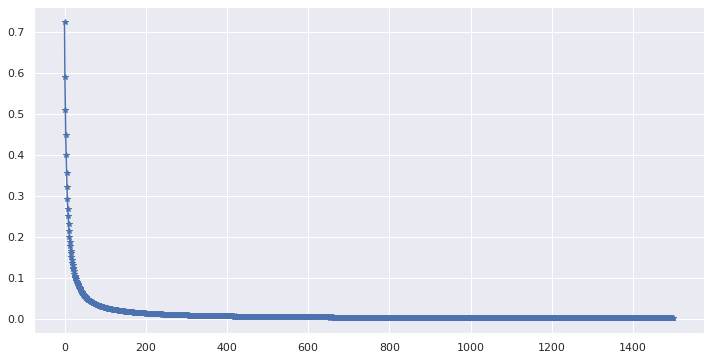

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [71]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

In [72]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с регуляризацией L2

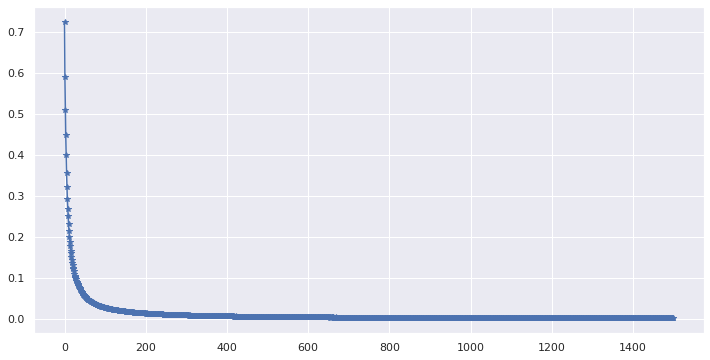

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [73]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

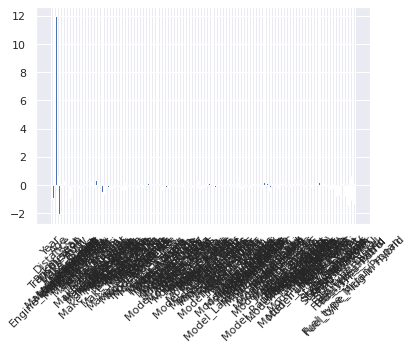

In [74]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

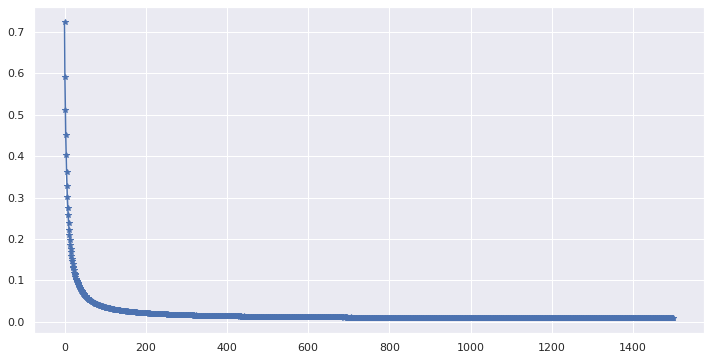

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [75]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

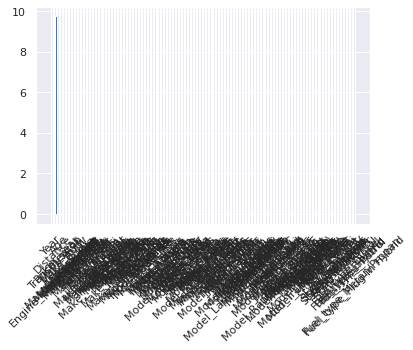

In [76]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Эластичная регрессия

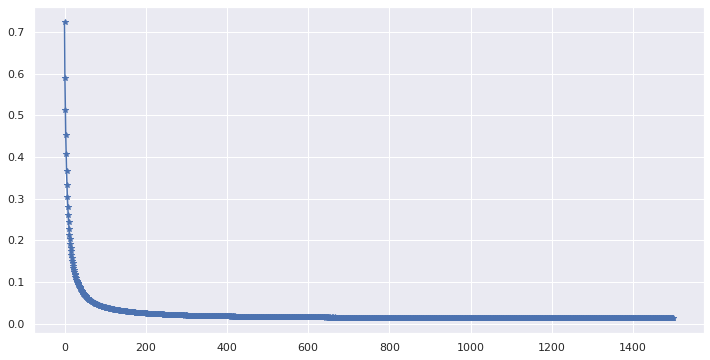

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [77]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

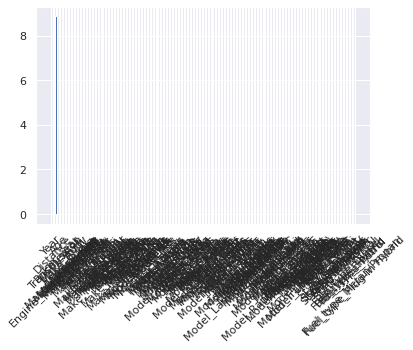

In [78]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Посмотрим, можно ли проводить классификацию без параметров связанных с расстоянием

In [79]:
w, b = regr.get_w_and_b()

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

train ACC: 1.0000; test ACC: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


#One-hot кодирование

## Загрузка данных на Google Drive

In [29]:
uploaded = files.upload()

Saving cars_moldova_onehot.csv to cars_moldova_onehot.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [30]:
df = pd.read_csv('/content/cars_moldova_onehot.csv', delimiter = ',')
df

,Year,Distance,Engine_capacity(cm3),Transmission,Price(euro),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,2011,195000.0,1800.0,1,7750.0,11,17727.272727,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2014,135000.0,1500.0,0,8550.0,8,16875.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,2012,110000.0,1500.0,0,6550.0,10,11000.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,2006,200000.0,1600.0,0,4100.0,16,12500.000000,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2000,300000.0,2200.0,0,3490.0,22,13636.363636,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,2016,88000.0,1800.0,1,11500.0,6,14666.666667,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32216,2002,225000.0,1800.0,0,4400.0,20,11250.000000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32217,2015,89000.0,1500.0,0,7000.0,7,12714.285714,0,0,0,...,0,0,0,1,1,0,0,0,0,0
32218,2006,370000.0,2000.0,0,4000.0,16,23125.000000,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Transmission', 'Price(euro)', 'Age', 'km_year', 'Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo', 'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford', 'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes', 'Make_Mini', 'Make_Mitsubishi', 'Make_Moskvich / Izh', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Rare', 'Make_Renault', 'Make_Rover', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong', 'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz', 'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206', 'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3', 'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series', 'Model_6', 'Model_626', 

## Логистическая регрессия

Запишим данные для классификации.

In [89]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
22549,0.40,0.011012,0.291667,0.0,0.006513,0.60,0.005179,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22550,0.74,0.208921,0.270833,1.0,0.061112,0.26,0.297166,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22551,0.84,0.155127,0.270833,0.0,0.078146,0.16,0.343601,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22552,0.84,0.219922,0.229167,1.0,0.066132,0.16,0.487865,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22553,0.94,0.049905,0.375000,1.0,0.251503,0.06,0.248497,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Проведем тестирование без регуляризации 

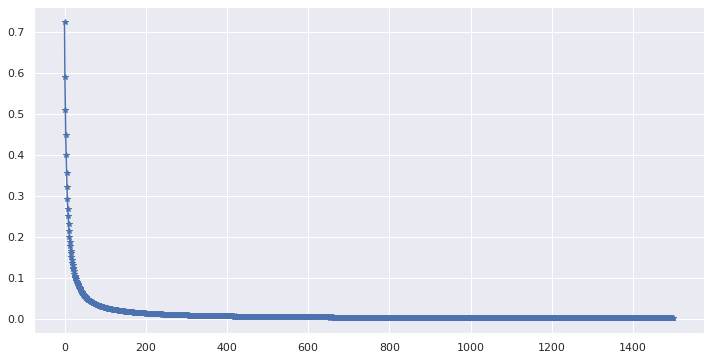

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [90]:
regr = LogisticRegression(learning_rate=0.08,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

In [99]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(199,100))
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с регуляризацией L2

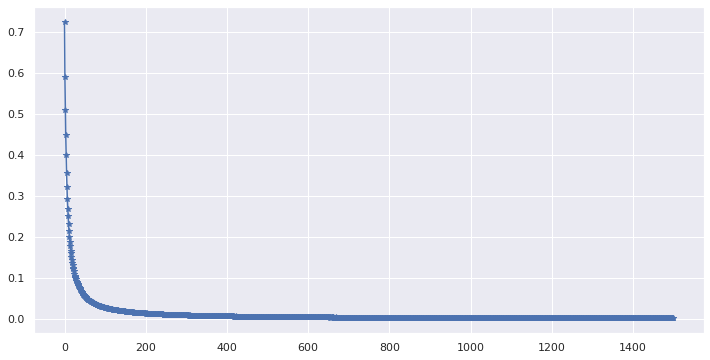

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [92]:
regr = LogisticRegression(learning_rate=0.05,epochs=1500,batch_size=5000, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

In [100]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(199,100))
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

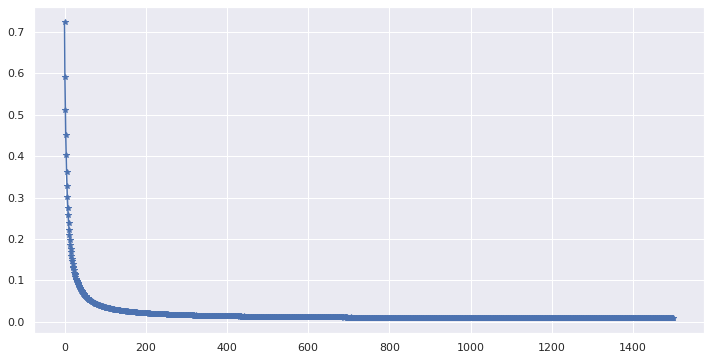

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [94]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

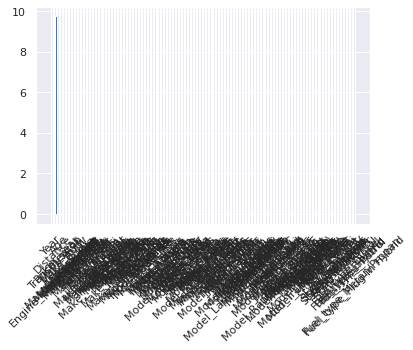

In [95]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Эластичная регрессия

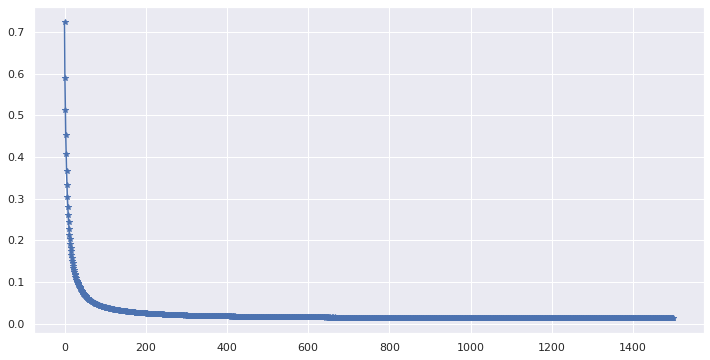

train Accuracy: 1.0000; test Accuracy: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [96]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

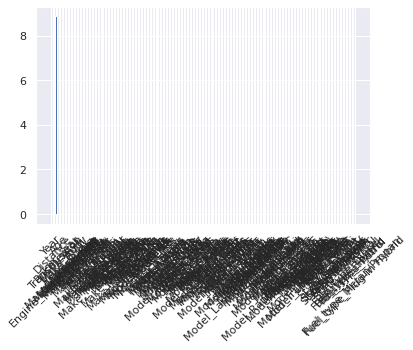

In [97]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Посмотрим, можно ли проводить классификацию без параметров связанных с расстоянием

In [98]:
w, b = regr.get_w_and_b()

w[1] = 0
w[-1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b)


print( 'train ACC: %.4f; test ACC: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

train ACC: 1.0000; test ACC: 1.0000
True Positives:4405	False Positives:0
False Negatives:0	True Negatives:5261
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000
